# Méthodes de descentes de gradients

Ce notebook est consacré à l'implémentation d'algorithmes de descentes de gradients vus en cours. Nous abordons d'abord le problème sous un angle général en pointant les problèmes qu'on peut rencontrer dans ce cadre là. Dans la suite on s'attaque plutôt à des problématiques plus standards en analyse de données ; celles-ci ont des solutions dont le comportement est plus stable. 


In [129]:
import warnings

import numpy as np
import matplotlib.pyplot as plt

## Algo général

Il prend le format suivant

In [329]:
def gradient_descent(x, ob_function, d_direction, 
                     rate=(lambda x, y: 0.01),
                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                     tolerance=0.0001, max_iter=1000,
                     plot_f=(lambda x, y: None)):
    """Gradient Descent.
    
    Computes minimal value of a convex function and local minimum of none convex function.
    
    Args:
        x (ndarray): initial starting point for descent.
        ob_function: objective function of optimisation problem, has input ndarray and outputs float.
        d_direction: function computing descent direction, outputs ndarray.
        rate: function computing learning rate, outputs float.
        decay_function: function computing decay, outputs float.
        tolerance (float): slack tolerance.
        max_iter (int): upper bound on number of iterations.      
        plot_f: plotting function for iteration points.
         
    Output:
        (int, int) minimizer, minimal value.
        
    """
    n_iter = 0
    decay = tolerance + 10  # Make sure that we get into first loop
    y = ob_function(x)
    while decay > tolerance and n_iter < max_iter:
        x = x - rate(ob_function, n_iter) * d_direction(ob_function, x)
        tmp_y = ob_function(x)
        decay = decay_function(y, tmp_y)
        y = tmp_y
        n_iter += 1
        plot_f(x, y)
    msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
    print(msg.format(n_iter, x.flatten(), y[0], decay))
    return (x, y) if decay <= tolerance else warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)

Pour être en mesure d'utiliser cet algorithme qui couvre l'essentiel des cas auxquels on peut faire face, il est nécessaire de définir les différents paramètres en entrées selon les descentes qu'on souhaite implémenter.
 

## Le pas de descente

On a abordé trois manières de calculer le pas de descente:

  - Un pas constant.
  - Calcul du pas optimal.
  - Le backtracking.
  
Seul la dernière stratégie nécessite l'affinage éventuel d'hyperparamètres, les fameux hyperparamètres $\alpha$ et $\beta$. Par défaut on les fixent respectivement à $0.01$ et $0.8$. Pour l'instant on se limite au cas du pas constant. Il sera suggéré dans la suite d'implémenter le cas d'un pas décroissant puis du backtracking.

## Directions de descentes

On a vu jusqu'à présent trois types de descentes : 

 - La déscente standard : la direction de descente est celle du gradient.
 - La déscente de plus forte pente dans le cas de la norme l1 : la direction de descente suit le vecteur de la base canonique de plus grande dérivée partielle.
 - L'algorithme de Newton où il s'agit de calculer l'inverse des hessiennes au point courant. 
 
*L'algorithme de Newton sera abordé dans l'extension de ce TP.*
 
Avant de s'intéresser à chacune de ces approches il nous faut être en mesure de calculer la valeur du gradient en un point courant. Tous les algos de descente font usage de ce calcul. On commence donc par un apparté sur ce point qui reste relativement technique. 

**Dans la pratique quand on fait face à un problème spécifique, et pour lequel on peut calculer le gradient de la fonction objective explicitement, on effectue ce calcule préalablement. Il est donc codé en dur.**


### Calculer le gradient d'une fonction

Vous êtes invités à regarder la documentation `scipy` pour `derivative` et celle de `numpy` pour `gradient`. Elles donnent des approximations numériques respectivement de la dérivée d'une fonction à valeur numérique et du gradient d'une fonction éventuellement à plusieurs variables.

Dans ce notebook on choisit d'utiliser la fonction derivative de `scipy`.

In [131]:
from scipy import misc

In [249]:
def partial_derivative(ob_function, point, var=0):
    args = point
    def wraps(x):
        args[var] = x
        return ob_function(args)
    return misc.derivative(wraps, point[var], dx=1e-6)

### Calculer les directions de descentes

- Cas de la descente de gradient standard.

In [283]:
def d_gd(ob_function, x):
    dim = x.shape[0]
    gradient = partial_derivative(ob_function, x, 0)
    for i in range(1, dim):
        gradient = np.vstack((gradient, partial_derivative(ob_function, x, i)))
    return gradient

- Cas de la descente de gradient à pas optimal en norme l1

In [318]:
def d_sgd(ob_function, x):
    dim = x.shape[0]
    sdescent = np.array([0]*dim, dtype=float).reshape(-1, 1)
    max_diff, imax_diff = sdescent[0], 0
    for i in range(dim):
        diff_i = abs(partial_derivative(ob_function, x, i))
        if  diff_i[0] > max_diff:
            imax_diff, max_diff = i, diff_i
    sdescent[imax_diff] = max_diff 
    return sdescent      

- Cas de l'algorithme de Newton

## Visualiser la convergence

Dans le cas des problèmes d'optimisation où la fonction objective est une fonction à une ou deux variables réelles, il est possible de visualiser les itérations de l'algorithme de descente. Dans le cas de la dimension $1$ on est en mesure de tracer le graphe de la fonction objective, dans le second quelques courbes de niveaux. 

On va choisir d'écire deux fonctions qui correspondent chacune au cas d'une des deux dimensions. *Comme tout ce qui est dans ce notebook, une approche plus orientée objet pourrais rendre un code plus élégant.*

### Cas de la dimension $1$

In [291]:
def plot_1d(ob_function, xmin=-5, xmax=5, nb_pts=100):
    x = np.linspace(xmin, xmax, nb_pts)
    y = ob_function(x)
    plt.plot(x, y, 'r-')

### Cas de la dimension $2$

In [292]:
def plot_2d(ob_function, xmin=-2, xmax=2, ymin=-2, ymax=2, nb_pts_h=50, nb_pts_v=50):
    x1 = np.linspace(xmin, xmax, nb_pts_h)
    x2 = np.linspace(ymin, ymax, nb_pts_v)
    X, Y = np.meshgrid(x1, x2)
    Z = ob_function(np.stack((X,Y), axis=0))
    plt.contour(X, Y, Z, cmap='RdGy')

## Tests en dimensions $1$ et $2$

### En dimension 1

In [293]:
def objective_1d(x):
    return 3*x*x + 2*x + 1

 Iteration nu. = 6
 approx. = [-0.33305517]
 ob value = 0.6666668987966661
 and decay = 5.529469861209613e-06.


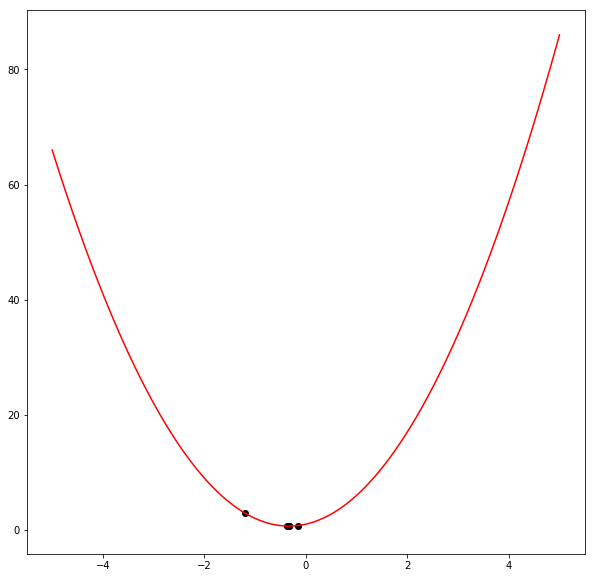

In [330]:
plt.figure(figsize=(10,10))
plot_1d(objective_1d)

x_star, p_star = gradient_descent(np.array([4], dtype=float), objective_1d, d_gd,
                                  rate=(lambda x, y: 0.2),
                                  plot_f=(lambda x, y:plt.scatter(x, y, c='k')))

plt.show()

### En dimension 2

In [295]:
def objective_2d(x):
    return -1.0 * np.exp(- x[0]**2 - x[1]**2)

 Iteration nu. = 7
 approx. = [  2.12188599e-04   6.12273620e-07]
 ob value = -0.9999999549756245
 and decay = 2.3247331633169388e-05.


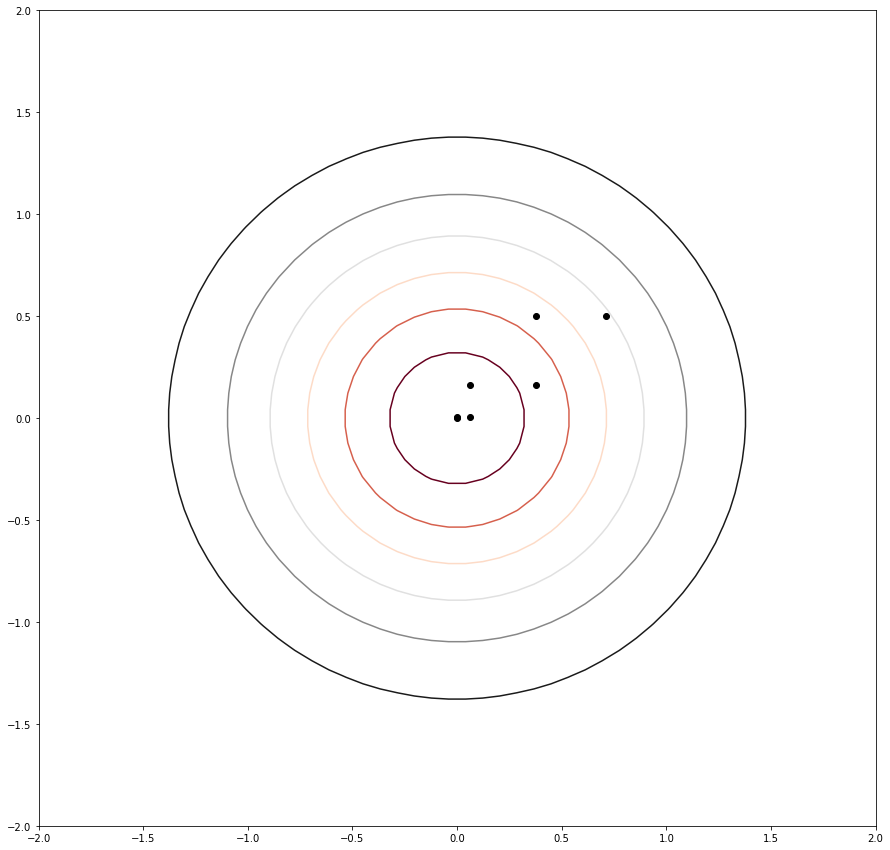

In [347]:
plt.figure(figsize=(15,15))
plot_2d(objective_2d)

x_star, p_star = gradient_descent(np.array([[1], [0.5]], dtype=float), objective_2d, d_sgd, rate=(lambda x, y: 1),
                                  plot_f=(lambda x, y:plt.scatter(x[0], x[1], c='k')))

plt.show()

## Mesurer la convergence

La question ici est d'écrire une fonction mesurant la performance d'un algorithme de descente. En effet, en général on sera pas en mesure de visualiser les itérations successives de l'algorithme. 

**Comment pourriez-vous procéder?**